# LSTM Classification of 6 Most Common Plastics from Fourier Transform Infrared Spectroscopy (FTIR)

Researchers from University of Mexico have published 6000 FTIR spectra of 6 most common plastics: High-Density Polyethylene (HDPE), Low-Density Polyethylene (LDPE), Polyethylene Terephthalate (PET), Polypropylene (PP), Polystyrene (PS), and Polyvinyl Chloride (PVC).

I have used this data with 1D convolution and 

Dataset provided on Zenodo:  
[![DOI](https://zenodo.org/badge/DOI/10.52821/zenodo.10736650.svg)](https://doi.org/10.52821/zenodo.10736650)

Instructions: To use this notebook, you must download the above dataset, unzip it to the folder "*your-repo*/data/", unzip both resultant folders in-place (FTIR-PLASTIC-c4 and FTIR-PLASTIC-c8) and then unzip the six folders inside each of those folders in-place (HDPE, LDPE, PET, PP, PS, and PVC). The unzipped data occupies about 196MB. 


In [1]:
# Utility and preprocessing imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# LSTM components for sequence classification
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [46]:
# Set up some environment variables

# Our random state for splitting
rseed=1812


# These are the plastics we'll be labeling
polymers = ['HDPE','LDPE','PET','PP','PS','PVC']

In [4]:
# Grab two same-material spectra, one from each set - ignore metadata, first column is wavenumber, second column is transmittance
sample_c8 = np.array(pd.read_csv(f"data/FTIR-PLASTIC-c8/HDPE_c8/HDPE54.csv", skiprows=range(0,14)))
sample_c4 = np.array(pd.read_csv(f"data/FTIR-PLASTIC-c4/HDPE_c4/HDPE54.csv", skiprows=range(0,14)))
sample_c8

array([[ 399.1927,  105.355 ],
       [ 401.1211,  104.055 ],
       [ 403.0496,  102.816 ],
       ...,
       [3997.7119,  102.301 ],
       [3999.6404,  102.306 ],
       [4001.5688,  102.29  ]])

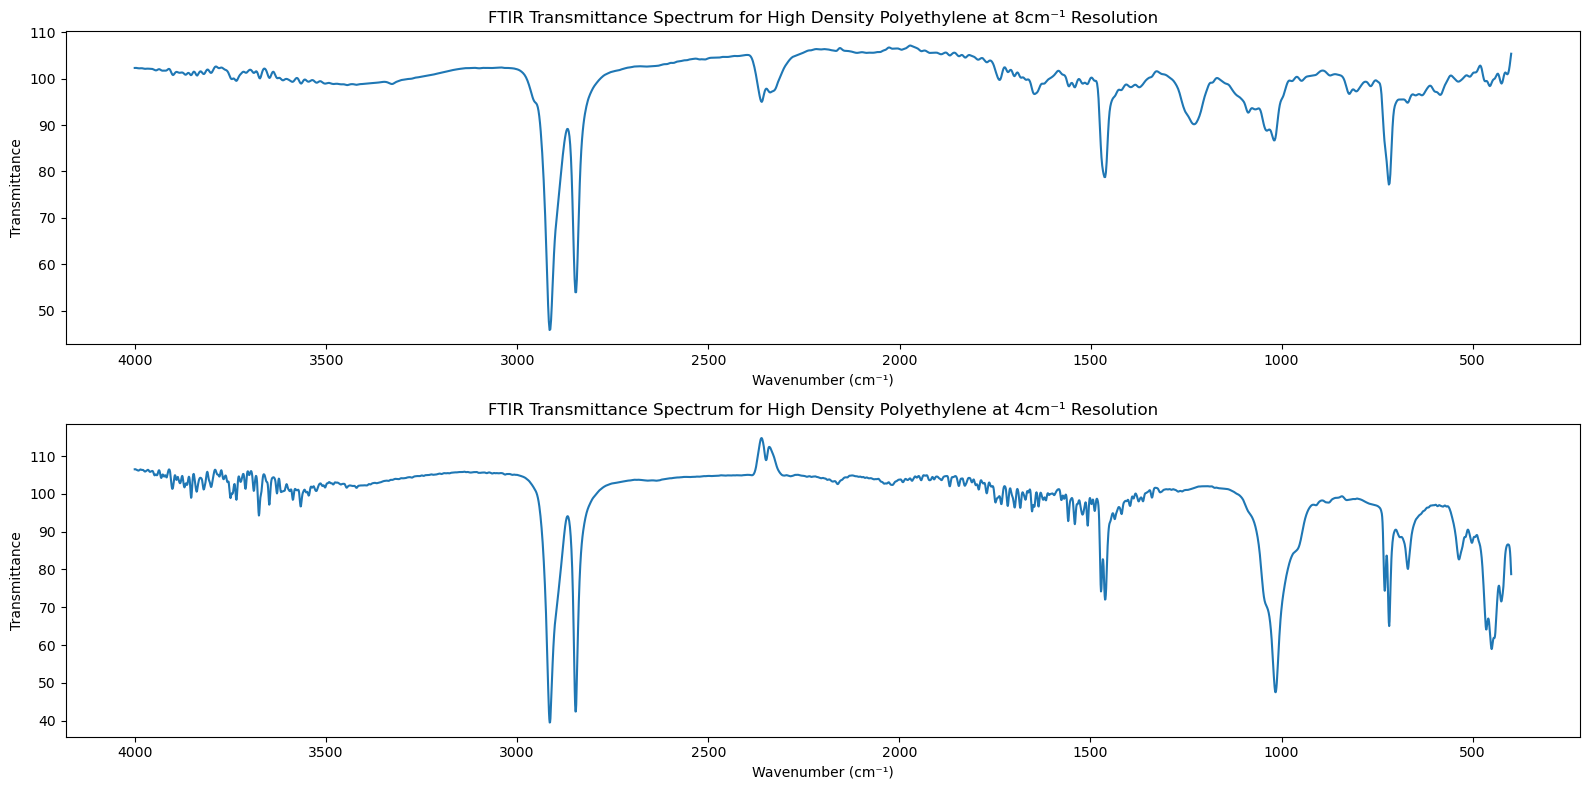

In [5]:
#vizualize our sample spectra
fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(16,8))
sns.lineplot(x=sample_c8[:,0], y=sample_c8[:,1],ax=ax1)
ax1.set_xlabel("Wavenumber (cm⁻¹)")
ax1.set_ylabel("Transmittance")
ax1.set_title("FTIR Transmittance Spectrum for High Density Polyethylene at 8cm⁻¹ Resolution")
ax1.invert_xaxis() 
sns.lineplot(x=sample_c4[:,0], y=sample_c4[:,1],ax=ax2)
ax2.set_xlabel("Wavenumber (cm⁻¹)")
ax2.set_ylabel("Transmittance")
ax2.set_title("FTIR Transmittance Spectrum for High Density Polyethylene at 4cm⁻¹ Resolution")
ax2.invert_xaxis() 
plt.tight_layout()

So, this is NOT gorgeous FTIR data - and that's ok! Transmissions obviously should never go over 100%, so there are some calibration issues, but we care a lot more about the shape than the actual values, especially for just classifying to the general material. This is still human-readable for this task, the signal structure is consistent, and most importantly it's a very large set for this kind of data.  

In [6]:
# First double-check the assumption that taking every other point in c4 spectrum gets the same wavenumbers as c8 minus the last datapoint.

assert np.equal(sample_c4[::2,0],sample_c8[:-1,0]).all()

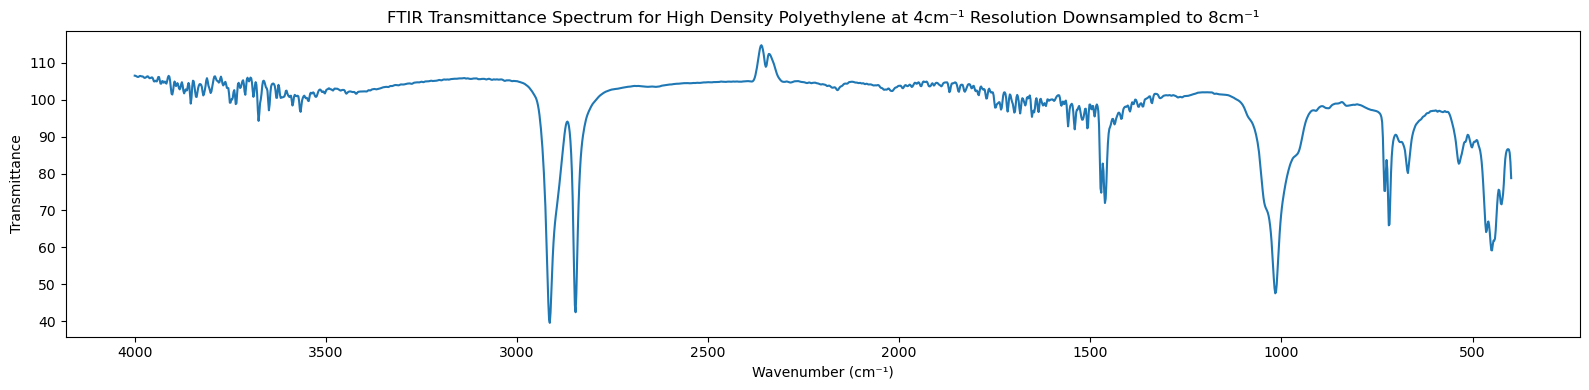

In [7]:
# Down-convert 4cm⁻¹ spectra and visualize to confirm correctness.

fig,ax = plt.subplots(figsize=(16,4))
sns.lineplot(x=sample_c4[::2,0],y=sample_c4[::2,1])
ax.set_xlabel("Wavenumber (cm⁻¹)")
ax.set_ylabel("Transmittance")
ax.set_title("FTIR Transmittance Spectrum for High Density Polyethylene at 4cm⁻¹ Resolution Downsampled to 8cm⁻¹")
ax.invert_xaxis() 
plt.tight_layout()

In [ ]:
# Time to get our full dataset loaded or built. 
if os.path.exists('data/data_train.csv'):
    data_train = pd.read_csv('data/data_train.csv', index_col=False)
    data_test = pd.read_csv('data/data_test.csv', index_col=False)

else:
    # Now that we know how to do direct conversion, we can import everything 
    data = np.hstack((sample_c8[:-1,0]))
    labels = ['label']


    for pm in polymers:

        for n in range(1,501): # samples are labeled 1 to 500 for each material in both c4 and c8 sets.
            data = np.vstack([
                                data,
                                np.array(pd.read_csv(f"data/FTIR-PLASTIC-c4/{pm}_c4/{pm}{n}.csv",skiprows=range(0,14)))[::2,1],
                                np.array(pd.read_csv(f"data/FTIR-PLASTIC-c8/{pm}_c8/{pm}{n}.csv",skiprows=range(0,14)))[:-1,1]
                                ])
            labels=np.vstack([labels,[pm],[pm]])
    

    # Need to divide signals by 100 to bring percentages to (mostly) between 0 and 1. 
    # I think relative signal intensities might be important between HDPE and LDPE 
    # so I'm opting not to further normalize signals for now

    data[1:,:] = data[1:,:]/100

    # And here's the whole thing!    
    data_df = pd.DataFrame(data[1:,:], columns=data[0,:])
    data_df['label'] = labels[1:]

    # Now let's split off a holdout set and then save both sets to avoid having to preprocess again.
    data_test, data_train = train_test_split(data_df, train_size=0.15, random_state=rseed)

    # Lets save that back out so we can load it up in just a second next time.
    data_train.to_csv('data/data_train.csv', index=False)
    data_test.to_csv('data/data_test.csv', index=False)



In [9]:
data_train.head(15)

,399.1927,401.1211,403.0496,404.9781,406.9065,408.835,410.7635,412.6919,414.6204,416.5489,...,3984.2126,3986.1411,3988.0696,3989.998,3991.9265,3993.855,3995.7834,3997.7119,3999.6404,label
0,0.945961,0.964486,0.980928,0.993397,1.001330,1.002310,0.998090,0.994694,0.991937,0.983539,...,1.008670,1.008870,1.008150,1.007300,1.007060,1.007330,1.007930,1.008570,1.008690,PS
1,0.809655,0.805031,0.795515,0.791262,0.792448,0.795575,0.798560,0.797837,0.793198,0.792618,...,1.035150,1.035170,1.035240,1.035310,1.035360,1.035380,1.035310,1.035200,1.035180,PVC
2,0.796955,0.835657,0.855075,0.861155,0.860699,0.857605,0.851536,0.840940,0.824175,0.797778,...,1.032410,1.032730,1.031760,1.030640,1.030520,1.031130,1.032070,1.032990,1.033250,HDPE
3,0.990981,0.992019,0.993716,0.995531,0.997020,0.997845,0.997776,0.996734,0.994874,0.992641,...,0.971808,0.971791,0.971734,0.971666,0.971612,0.971590,0.971600,0.971625,0.971646,PP
4,0.994545,1.003460,1.008030,1.010370,1.012290,1.014970,1.017900,1.018600,1.014630,1.006780,...,1.013790,1.014000,1.013300,1.012560,1.012600,1.013040,1.013510,1.014010,1.014240,LDPE
5,0.979895,0.994678,1.004160,1.014110,1.022350,1.025330,1.027570,1.029430,1.021800,1.003980,...,1.069150,1.069530,1.068540,1.067410,1.067380,1.068030,1.068870,1.069730,1.070070,LDPE
6,0.936071,0.940017,0.944230,0.947624,0.949744,0.950618,0.950498,0.949708,0.948599,0.947565,...,1.053300,1.053300,1.053220,1.053120,1.053040,1.053040,1.053120,1.053240,1.053360,PET
7,0.916840,0.941423,0.960024,0.970743,0.975566,0.975559,0.974027,0.973916,0.970049,0.957469,...,1.028090,1.028370,1.027690,1.026690,1.026250,1.026550,1.027400,1.028220,1.028420,PS
8,1.024240,1.023930,1.025530,1.027900,1.030100,1.031380,1.031140,1.028990,1.025030,1.020000,...,1.089420,1.089340,1.089150,1.088970,1.088890,1.088990,1.089230,1.089530,1.089760,LDPE
9,0.845134,0.844998,0.839748,0.837216,0.841705,0.846720,0.844996,0.839737,0.836067,0.832928,...,0.983769,0.983774,0.983637,0.983493,0.983486,0.983588,0.983762,0.983962,0.984075,PET


In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5100 entries, 0 to 5099
Columns: 1869 entries, 399.1927 to label
dtypes: float64(1868), object(1)
memory usage: 72.7+ MB


In [11]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Columns: 1869 entries, 399.1927 to label
dtypes: float64(1868), object(1)
memory usage: 12.8+ MB


In [12]:
data_train.isna().sum().value_counts(), data_train.isna().sum().value_counts() # no nulls

(0    1869
 Name: count, dtype: int64,
 0    1869
 Name: count, dtype: int64)

In [13]:
# Assign X and y 
# One-hot the target classes 
encoder=OneHotEncoder()
y_train=encoder.fit_transform(np.array(data_train['label']).reshape(-1,1)).toarray()
y_test=encoder.transform(np.array(data_test['label']).reshape(-1,1)).toarray()

# Let's invert from transmission to absorbance for a more traditional signal shape (baseline near 0, peaks near 1) to hopefully help our model out 
X_train=data_train.drop(columns=['label']).multiply(-1).add(1)
X_test=data_test.drop(columns=['label']).multiply(-1).add(1)

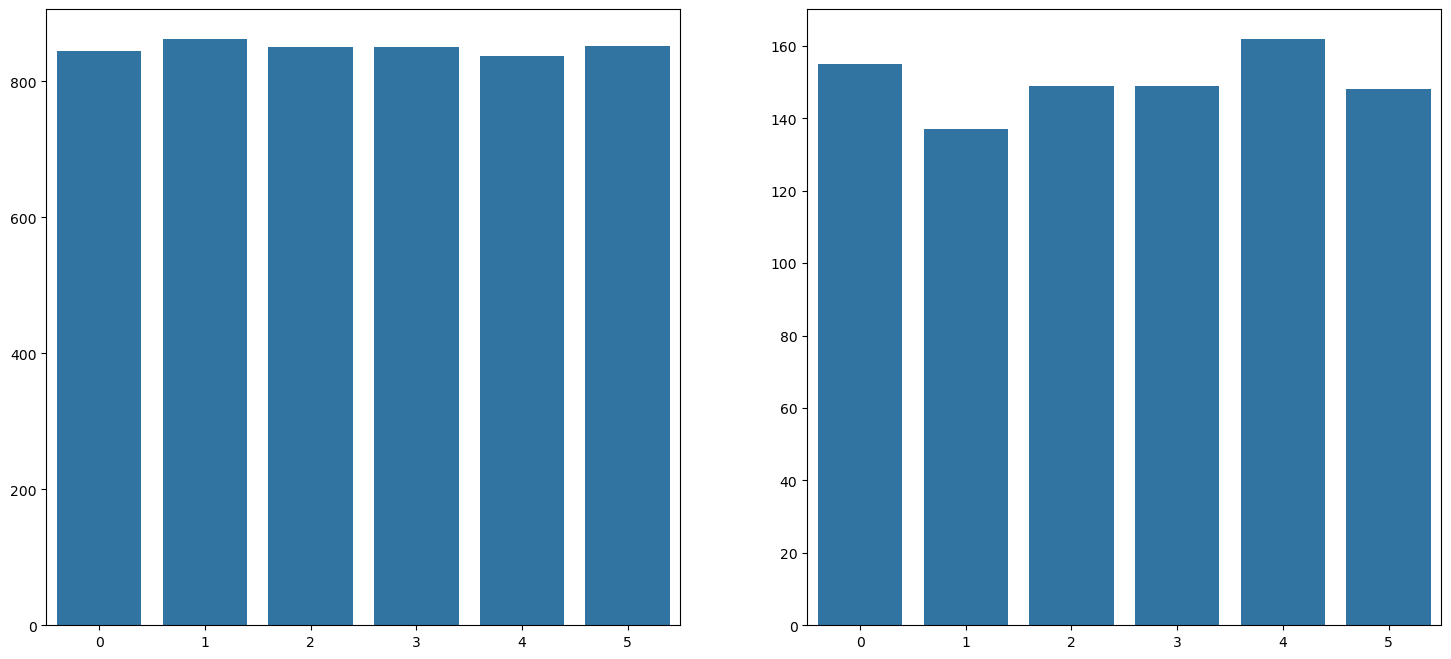

In [14]:
# Quick histograms to make sure target distributions are still balanced enough
fig,[ax1,ax2] =plt.subplots(ncols=2,figsize=(18,8))
sns.barplot(x=[0,1,2,3,4,5],y=[y_train[:,0].sum(),y_train[:,1].sum(),y_train[:,2].sum(),y_train[:,3].sum(),y_train[:,4].sum(),y_train[:,5].sum()],ax=ax1)
sns.barplot(x=[0,1,2,3,4,5],y=[y_test[:,0].sum(),y_test[:,1].sum(),y_test[:,2].sum(),y_test[:,3].sum(),y_test[:,4].sum(),y_test[:,5].sum()],ax=ax2);

Our test is a little lumpy, but seems like it should be ok. 

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)).astype('float64')


I started with Kash's RNN time series tutorial model but pure LSTM didn't work well right away, so I dropped an LSTM layer and added convolutional input layers and a dense layer first to better identify/articulate signal features before sending to LSTM to put the pieces together. I chose my kernel size and strides based on the usual size window of wavenumbers given for assigning specific bond resonances to signal peaks. 

In [38]:
INPUT_CONVOLUTIONAL_LAYER = Conv1D(filters= 200,
                                    kernel_size = 20,
                                    strides=10,
                                    padding='valid',
                                    activation='relu',
                                    input_shape=(X_train.shape[1], 1))
SECOND_CONVOLUTIONAL_LAYER = Conv1D(filters=50, 
                                    kernel_size=20, 
                                    strides=10, 
                                    padding='valid',
                                    activation='relu')

FIRST_RECURRENT_LAYER =    LSTM(50, return_sequences=True)
SECOND_RECURRENT_LAYER =  LSTM(50, return_sequences=True)
THIRD_RECURRENT_LAYER =   LSTM(50)


FIRST_DROPOUT_LAYER =     Dropout(0.3)
SECOND_DROPOUT_LAYER =    Dropout(0.2)
THIRD_DROPOUT_LAYER =    Dropout(0.1)
FOURTH_DROPOUT_LAYER =    Dropout(0.1)


FIRST_CONNECTIVE_LAYER = Dense(50, activation='relu')
OUTPUT_CONNECTIVE_LAYER = Dense(6,activation='softmax')

In [39]:
model = Sequential()

model.add(INPUT_CONVOLUTIONAL_LAYER)
model.add(FIRST_DROPOUT_LAYER)
model.add(SECOND_CONVOLUTIONAL_LAYER)
model.add(SECOND_DROPOUT_LAYER)
model.add(FIRST_CONNECTIVE_LAYER)
model.add(FIRST_RECURRENT_LAYER)
model.add(THIRD_DROPOUT_LAYER)
model.add(SECOND_RECURRENT_LAYER)
model.add(FOURTH_DROPOUT_LAYER)
model.add(THIRD_RECURRENT_LAYER)
model.add(OUTPUT_CONNECTIVE_LAYER)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 185, 200)          4200      
                                                                 
 dropout_14 (Dropout)        (None, 185, 200)          0         
                                                                 
 conv1d_11 (Conv1D)          (None, 17, 50)            200050    
                                                                 
 dropout_15 (Dropout)        (None, 17, 50)            0         
                                                                 
 dense_8 (Dense)             (None, 17, 50)            2550      
                                                                 
 lstm_12 (LSTM)              (None, 17, 50)            20200     
                                                                 
 dropout_16 (Dropout)        (None, 17, 50)           

In [40]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [41]:
# Run 10 iterations and see what happens
short_history1 = model.fit(X_train,y_train,
                    epochs=10, batch_size=32,
                    verbose=True, validation_split=0.2)

Epoch 1/10
128/128 [==============================] - 9s 41ms/step - loss: 1.1519 - accuracy: 0.5377 - val_loss: 0.5661 - val_accuracy: 0.7735
Epoch 2/10
128/128 [==============================] - 4s 32ms/step - loss: 0.4795 - accuracy: 0.8186 - val_loss: 0.3538 - val_accuracy: 0.8657
Epoch 3/10
128/128 [==============================] - 4s 32ms/step - loss: 0.3249 - accuracy: 0.8762 - val_loss: 0.3100 - val_accuracy: 0.8784
Epoch 4/10
128/128 [==============================] - 4s 32ms/step - loss: 0.2457 - accuracy: 0.9078 - val_loss: 0.2177 - val_accuracy: 0.9245
Epoch 5/10
128/128 [==============================] - 4s 32ms/step - loss: 0.2159 - accuracy: 0.9243 - val_loss: 0.1391 - val_accuracy: 0.9598
Epoch 6/10
128/128 [==============================] - 4s 32ms/step - loss: 0.1420 - accuracy: 0.9517 - val_loss: 0.1169 - val_accuracy: 0.9657
Epoch 7/10
128/128 [==============================] - 4s 32ms/step - loss: 0.1243 - accuracy: 0.9583 - val_loss: 0.0728 - val_accuracy: 0.9775

98% validation accuracy in under a minute! I'd call that a winner. 

In [42]:
# Use Kash's Model History Vizualization Function
def plot_training_results(history):
    """
    Visualize results of the model training using `matplotlib`.

    The visualization will include charts for accuracy and loss,
    on the training and as well as validation data sets.

    INPUTS:
        history(tf.keras.callbacks.History):
            Contains data on how the model metrics changed
            over the course of training.

    OUTPUTS:
        None.
    """
    # Get accuracy for training and validation sets
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Get loss for training and validation sets
    loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Get range of epochs to produce common plotting range
    epochs_range = history.epoch

    # Instantiate plotting figure space
    plt.figure(figsize=(20, 8))

    # Create training/validation accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Create training/validation loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Render visualization
    plt.show()

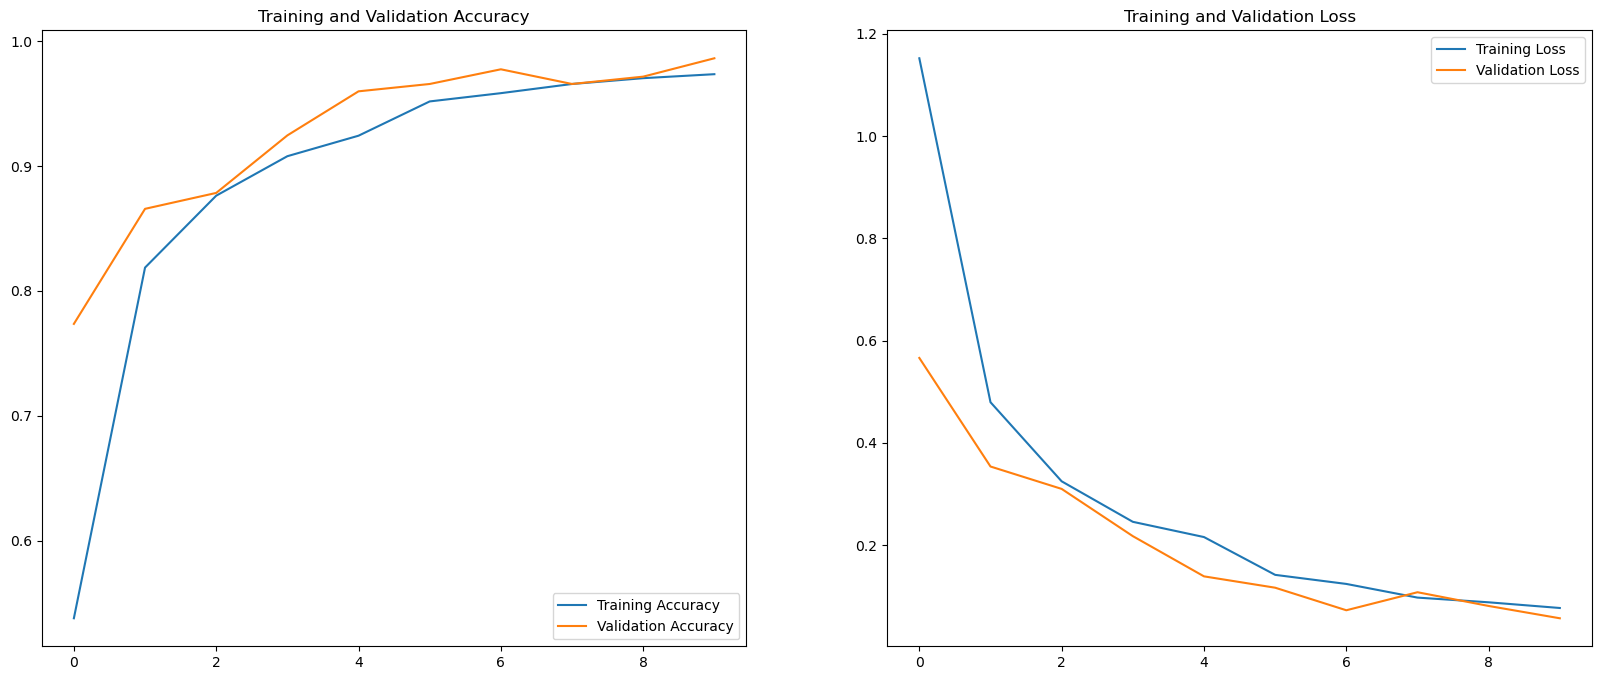

In [43]:
plot_training_results(short_history1)

Looking really nice! Seems like this model would like a little more time to fully stabilize, but I expect good things!

In [44]:
y_pred = model.predict(X_test)

29/29 [==============================] - 1s 9ms/step


In [47]:
# Change one-hot back to labels to use sklearn metrics
y_pred_labeled = [polymers[np.argmax(row)] for row in y_pred]
y_test_labeled = [polymers[np.argmax(row)] for row in y_test]

In [48]:
accuracy_score(y_true=y_test_labeled,y_pred=y_pred_labeled)

0.9844444444444445

In [49]:
# borrow Kash's cmat to make my confusion matrix pretty
def cmat_(cm, labels=None):
  """ Helper function to visualize confusion matrix. """
  axis = plt.subplot()
  sns.heatmap(cm, annot=True, fmt="g", ax=axis)
  axis.set_title("Confusion Matrix")
  axis.set_xlabel("Predicted Labels")
  axis.set_ylabel("True Labels")
  if labels:
      axis.xaxis.set_ticklabels(labels)
      axis.yaxis.set_ticklabels(labels)
  plt.show()

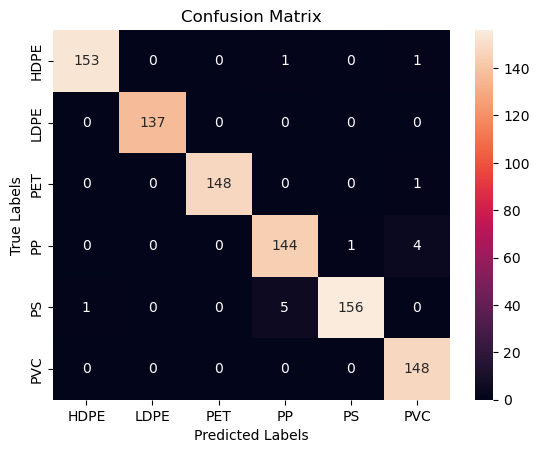

In [50]:
cmat_(confusion_matrix(y_true=y_test_labeled,y_pred=y_pred_labeled),labels=polymers)

Really good! HDPE and LDPE are genuinely hard to distinguish - I'm surprised the model did as well as it did with them! It looks like is struggled a bit with polypropylene too. 

# Conclusion and Next Steps